# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

sns.set_style('whitegrid')

import re
from random import sample
import math

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

from wordcloud import WordCloud

import os
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'}) 
mallet_path = r'C:/mallet-2.0.8/bin/mallet' 

In [2]:
jobs = pd.read_csv('test_data.csv')

In [3]:
jobs.head()

job_id  \
0  dc4c44bf442f4baa57f22233fee9195b75d62baa3b0265...   
1  39fc119781f2337a52de7300f21b76cda9b2c0202bfec9...   
2  2bdd91d7794575aaefee738ef6c831f7129fe6172f713c...   
3  0c170932727e0246f27feb1a5641d0e26f44d26d431be6...   
4  458658ef725f6384d4c056f6a8b01747331ba7c3c5c2e5...   

                                           job_title  \
0          BUSINESS DEVELOPMENT (FREIGHT FORWARDING)   
1                                       Secretary/PA   
2  Temporary 3-6months Admin Assistant (Office ho...   
3                                 Program Management   
4  Automotive Software Engineers (C Programming /...   

                                     job_description date_posted  \
0  - Roles &amp; Responsibilities : Job Role Desc...  27/11/2020   
1  - Roles &amp; Responsibilities : Job Scope:<br...  26/11/2020   
2  Monday to Friday Office hoursLocation : Buona ...  14/11/2020   
3  - Roles &amp; Responsibilities : Key Responsib...   9/11/2020   
4  &bull; MNC&bull; $3500 - $6000 Basic + AWS + V...  15/11/2020   

                               company_name  
0             CALL LADE ENTERPRISES PTE LTD  
1             TALENT TRADER GROUP PTE. LTD.  
2                              Confidential  
3  YASH TECHNOLOGIES SINGAPORE PTE. LIMITED  
4                              Confidential

In [4]:
df = jobs.copy()

# EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_id           3000 non-null   object
 1   job_title        3000 non-null   object
 2   job_description  3000 non-null   object
 3   date_posted      3000 non-null   object
 4   company_name     3000 non-null   object
dtypes: object(5)
memory usage: 117.3+ KB


In [6]:
for column in df.columns:
    print(f"Number of unique {column}: {df[column].nunique()}")

Number of unique job_id: 3000
Number of unique job_title: 2883
Number of unique job_description: 2975
Number of unique date_posted: 48
Number of unique company_name: 901


In [7]:
df['date_posted'] = pd.to_datetime(df['date_posted'], dayfirst = True)

In [8]:
date_distribution = df.groupby('date_posted').count()['job_id']
date_distribution

date_posted
2020-11-01     18
2020-11-02     35
2020-11-03     30
2020-11-04     36
2020-11-05     83
2020-11-06     85
2020-11-07     23
2020-11-08     70
2020-11-09    146
2020-11-10    112
2020-11-11    114
2020-11-12    111
2020-11-13    107
2020-11-14     87
2020-11-15     98
2020-11-16     39
2020-11-17    155
2020-11-18    188
2020-11-19    203
2020-11-20    219
2020-11-21    121
2020-11-22     98
2020-11-23    131
2020-11-24    166
2020-11-25    200
2020-11-26    146
2020-11-27    134
2020-11-28      1
2020-12-02      5
2020-12-03      2
2020-12-04      1
2020-12-05      1
2020-12-06      4
2020-12-09      3
2020-12-11      4
2020-12-12      2
2020-12-13      3
2020-12-14      1
2020-12-16      2
2020-12-17      3
2020-12-18      3
2020-12-19      2
2020-12-20      1
2020-12-23      1
2020-12-26      2
2020-12-27      2
2020-12-30      1
2020-12-31      1
Name: job_id, dtype: int64

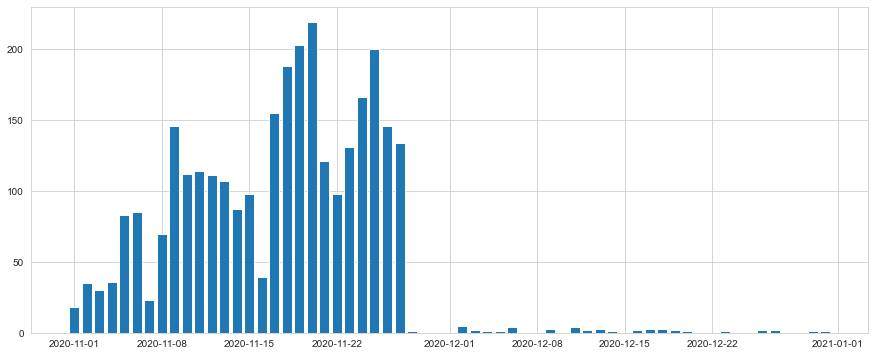

In [9]:
plt.figure(figsize = (15, 6))
plt.bar(date_distribution.index, date_distribution.values)
plt.show()

Seems like majority of jobs are posted in Nov and not so much in December. This could suggest that the "hiring season" starts from Nov where most of the jobs are posted and the hiring process continues into Dec/Jan, without much new job posted from December onwards.

# Job Description

## Data Cleaning

In [10]:
for jd in df['job_description'][:5]:
    print(jd)
    print()

- Roles &amp; Responsibilities : Job Role Description:<br/>&bull;	Responsible for business development for FREIGHT FORWARDING<br/>&bull;	Identify potential clients in the target market and complete appropriate research on the prospective client's business and equipment needs<br/>&bull;	Develop intervention strategies to mitigate gaps in delivery of logistics services<br/>&bull;	Develop relationships with potential customers and meeting sales targets<br/>&bull;	Negotiate contract terms with clients&nbsp;<br/>&bull;	Actively seeking out new sales opportunities through cold calling, networking and social media<br/><br/>Requirements:<br/>&bull;	Proven working experience as a business development, sales executive or a relevant role<br/>&bull;	Experience in customer support is a plus<br/>&bull;	Proficiency in MS Office&nbsp;<br/>&bull;	Market knowledge

- Roles &amp; Responsibilities : Job Scope:<br/><br/>Full spectrum of secretarial support to the CEO<br/>Provide support to the daily activi

In [11]:
def clean_text(text):
    patterns = {'<br>': ' ',
            '<br/>': ' ',
            '</br>': ' ',
            '\t': ' ',
            '&amp;': 'and', #&
            '&bull;': ' ', #bullet
            '&nbsp;': ' ', #non-breaking space
            '&sect;': ' ', #section
            '&rsquo;': '\'', #single quote '
            '&ndash;': ' ',
            '&ldquo;': ' ',
            '&rdquo;': ' ',
            '(&[a-z]+;)': ' ',
            '[^a-zA-Z\s]': ' ', #all none words and whitespace characters,
            r'\s+': ' ',
            r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))': r'\1 '}
    
    for pattern, replacement in patterns.items():
        text = re.sub(pattern, replacement, text)
        
    text = text.lower()
    
    return text

In [12]:
texts = df['job_description'].map(lambda x: clean_text(x))

In [13]:
for text in texts[:3]:
    print(text, '\n')

 roles and responsibilities job role description responsible for business development for freight forwarding identify potential clients in the target market and complete appropriate research on the prospective client s business and equipment needs develop intervention strategies to mitigate gaps in delivery of logistics services develop relationships with potential customers and meeting sales targets negotiate contract terms with clients actively seeking out new sales opportunities through cold calling networking and social media requirements proven working experience as a business development sales executive or a relevant role experience in customer support is a plus proficiency in ms office market knowledge 

 roles and responsibilities job scope full spectrum of secretarial support to the ceo provide support to the daily activities of the ceo including emails and meeting arrangements handle travel arrangements flight reservation hotel accommodation visa applications etc handle confi

In [14]:
for index in sample(range(len(texts)), 10):
    print(index)
    print(texts[index], '\n\n')

199
requirement minimum diploma in horticulture landscape management for horticulturist diploma advanced higher graduate diploma bachelor s degree post graduate diploma professional degree in agriculture aquaculture forestry or equivalent required language s acirc english mandarin in order to coordinate with english and mandarin speaking officers management agents in regards with the work arrangements site inspections meetings complaints or any other matters good knowledge in plant id possess a minimum class license preferably good command of written and spoken english willing to work in a diverse working environment able to handle adhoc work request beyond normal working hours no work experience required preferably entry level specialized in agriculture forestry fisheries or equivalent full time position s available responsibility oversee and supervise all landscaping works within the works area liase with officers management agents with regards to work arrangements site inspections m

In [15]:
# define function to get the pos of words in the sentence
def get_sent_post(sentence):
    word_tag = nltk.pos_tag(sentence)

    new_word_tag = []

    for word, tag in word_tag:
        new_tag = tag[0]
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}

        new_word_tag.append((word, tag_dict.get(new_tag, wordnet.NOUN)))
    
    return new_word_tag

# define function to conduct word pre-processing on the dataset
# includes tokenizing, removing stopwords, creating bigrams and trigrams and lemmatization
def lemmatize_words(corpus):
    
    # using NLTK's lemmatizer as it returns words into their base forms
    # it performs better than many other lemmatizer (and stemmers) as it takes into account the part-of-speech of the word
    texts_tokenized = [nltk.word_tokenize(text) for text in corpus]

    lemmatizer = WordNetLemmatizer()
    texts_lemmatized = [[lemmatizer.lemmatize(word, pos) for word, pos in get_sent_post(sentence)] for sentence in texts_tokenized]
    
    texts_out = [" ".join(sentence) for sentence in texts_lemmatized]
        
    return texts_out

In [16]:
df['jd_cleaned'] = lemmatize_words(texts)

In [17]:
for jd in df['jd_cleaned'][:2]:
    print(jd, '\n')

role and responsibility job role description responsible for business development for freight forward identify potential client in the target market and complete appropriate research on the prospective client s business and equipment need develop intervention strategy to mitigate gap in delivery of logistics service develop relationship with potential customer and meet sale target negotiate contract term with client actively seek out new sale opportunity through cold call networking and social medium requirement proven work experience a a business development sale executive or a relevant role experience in customer support be a plus proficiency in ms office market knowledge 

role and responsibility job scope full spectrum of secretarial support to the ceo provide support to the daily activity of the ceo include email and meet arrangement handle travel arrangement flight reservation hotel accommodation visa application etc handle confidential information and maintain the security of th

## EDA

In [18]:
# create a function that will return the top N most frequent k-gram words
# it also takes in the stopwords if needed, default is set to None
def top_n_kgram_words(corpus, n, k, stopwords=None):

    cvec = CountVectorizer(ngram_range=(k, k), stop_words=stopwords).fit(corpus)

    bag_of_words = cvec.transform(corpus)

    words_appearance = bag_of_words.sum(axis=0)

    words_freq = [(word, words_appearance[0, index])
                  for word, index in cvec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    return words_freq[:n]

# create a function that will plot barplots of the top N most frequent k-gram words
# it also takes in the stopwords if needed, default is set to None
def plot_top_n_kgram_words(corpus, n, k, stopwords, title, palette = 'Blues_r'):
    
    data = top_n_kgram_words(corpus, n, k, stopwords=stopwords)

    temp_df = pd.DataFrame(data = data, columns = ['Word', 'Frequency'])

    plt.figure(figsize=(8, 2+(n/2)))
    sns.barplot(data=temp_df, y='Word', x='Frequency', palette = palette)
    plt.title(title, fontsize=20)
    plt.ylabel('')
    plt.xlabel('')

    plt.show()

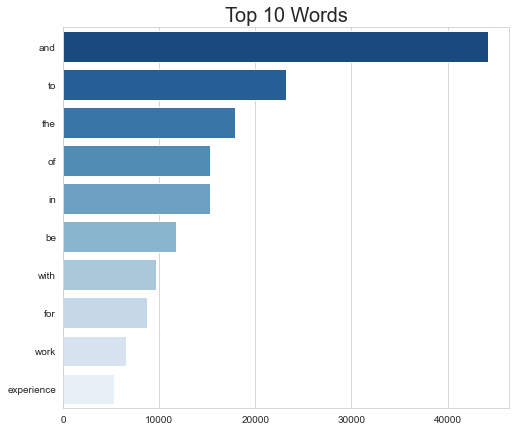

In [19]:
plot_top_n_kgram_words(df['jd_cleaned'], 10, 1, stopwords = None, title = 'Top 10 Words')

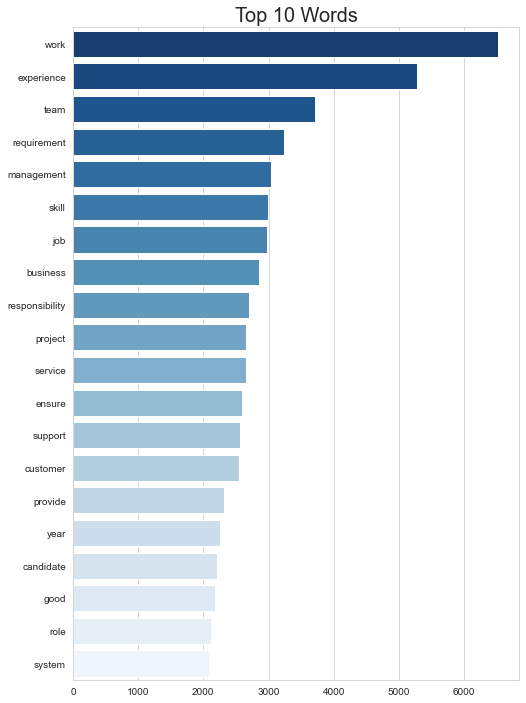

In [20]:
plot_top_n_kgram_words(df['jd_cleaned'], 20, 1, stopwords = stop_words, title = 'Top 10 Words')

Some words that does not add to the meaning:

work, experience, requirement, skill, job, responsibility, year, candidate, good, role

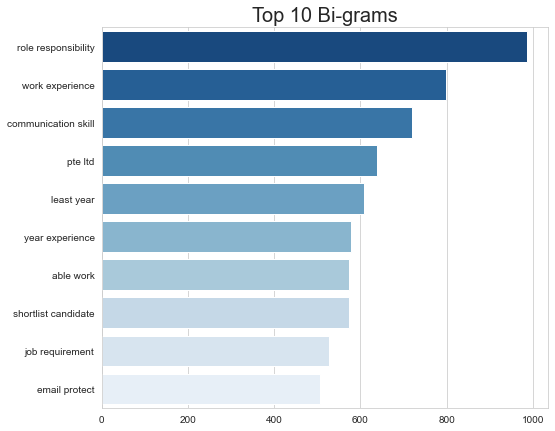

In [21]:
plot_top_n_kgram_words(df['jd_cleaned'], 10, 2, stopwords = stop_words, title = 'Top 10 Bi-grams')

pte, ltd, shortlist, candidate, email

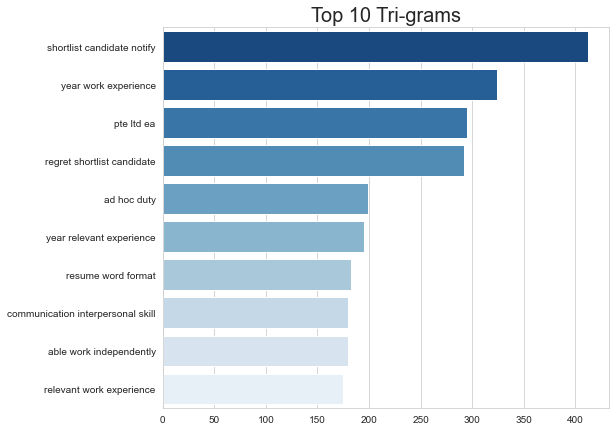

In [22]:
plot_top_n_kgram_words(df['jd_cleaned'], 10, 3, stopwords = stop_words, title = 'Top 10 Tri-grams')

resume

In [23]:
stop_words.update(['work', 'experience', 'requirement', 'skill', 'job', 'responsibility', 'year', 'candidate', 'good', 'role', 'pte', 'ltd', 'ea', 'shortlist', 'candidate', 'email', 'resume'])

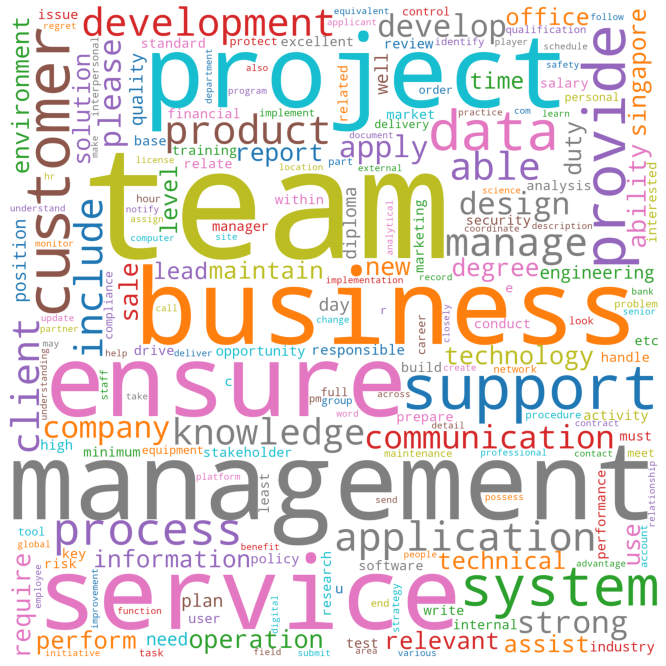

In [24]:
wordcloud = WordCloud(width=2000, 
                      height=2000,
                      background_color='white',
                      colormap = 'tab10',
                      random_state=11, 
                      collocations=False, 
                      stopwords=stop_words).generate(df['jd_cleaned'].str.cat())

plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Roles
- Project management seems to be a very common requirement
- Seem to have a number IT and data related roles

Traits
- Working in a team is a very important trait
- "ensure" suggests that responsibility is also a very important trait

Others
- "support" suggests that there may be a number of entry level roles that will be supporting others

## LDA Models

In [25]:
# define function to tokenize, remove stopwords, create bigrams and trigrams
def create_ngrams(corpus, stopwords):
    
    texts_tokenized = [nltk.word_tokenize(sentence) for sentence in corpus]
    
    texts = [[word for word in sentence if word not in stopwords] for sentence in texts_tokenized]
    
    # build the bigram and trigram models by automatically detecting common phrases / multiword expressions
    # min_count ignores all words and bigrams with total count less than the number
    # threshold affects the number of phrases that will be created (higher threshold = fewer phrases)
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=20)
    trigram = gensim.models.Phrases(bigram[texts], threshold=20)

    # a phrases object is for learning bigrams (and multiword expressions), not for processing
    # for processing, need to use a phraser object
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
 
    # combines bi-gram phrases
    texts_w_bigrams = [bigram_mod[sentence] for sentence in texts]
    
    # combines tri-gram phrases
    texts_w_trigrams = [trigram_mod[bigram_mod[sentence]] for sentence in texts_w_bigrams]
    
    return texts_w_trigrams

In [26]:
n_gram_texts = create_ngrams(df['jd_cleaned'], stop_words)

In [27]:
# define function to compute the coherence score of the LDA model across a range of topic numbers
# plot the coherence score against the number of topics
# this function will be used to determine optimal number topics for each LDA model
def compute_coherence_values(processed_texts, id2word, corpus, limit, start=3, step=1):

    coherence_values = []
    model_list = []
    topic_range = range(start, limit, step)

    for num_topics in topic_range:

        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=num_topics,
                                                    random_state=11,
                                                    chunksize=500,
                                                    passes=10,
                                                    iterations=100,
                                                    per_word_topics=True)

        model_list.append(lda_model)

        coherencemodel = CoherenceModel(model=lda_model,
                                        texts=processed_texts,
                                        dictionary=id2word,
                                        coherence='c_v')

        coherence_values.append(coherencemodel.get_coherence())

    plt.plot(topic_range, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.show()

    return model_list, coherence_values

In [28]:
# create a new dictionary of interger numbers and unique words in the entire dataset
id2word = corpora.Dictionary(n_gram_texts)

# create the term document frequency corpus
corpus = [id2word.doc2bow(text) for text in n_gram_texts]

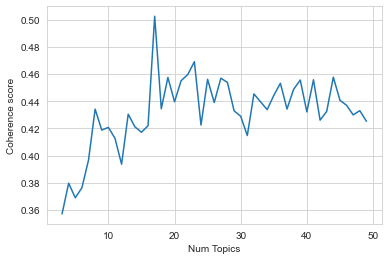

In [33]:
_, coherence_values = compute_coherence_values(processed_texts = n_gram_texts, 
                                id2word = id2word,
                                corpus = corpus,
                                start = 3,
                                limit = 50, 
                                step = 1)

In [29]:
lda_model_17 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=17,
                                               random_state=11,
                                               chunksize=500,
                                               passes=10,
                                               iterations=100,
                                               per_word_topics=True)

In [30]:
def plot_wordcloud(model):
    
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] * 5

    cloud = WordCloud(background_color='white',
                      width=2000,
                      height=1200,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0,)

    topics = model.show_topics(num_topics=0, formatted=False)
    topics = dict(topics)
    
    num_topics = len(topics)
    num_rows = math.ceil(num_topics/2)

    fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 4), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        if i < num_topics:
            fig.add_subplot(ax)
            topic_words = dict(topics[i])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.title('Topic ' + str(i), fontsize=20)
            plt.gca().axis('off')
        else:
            fig.delaxes(ax) 

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

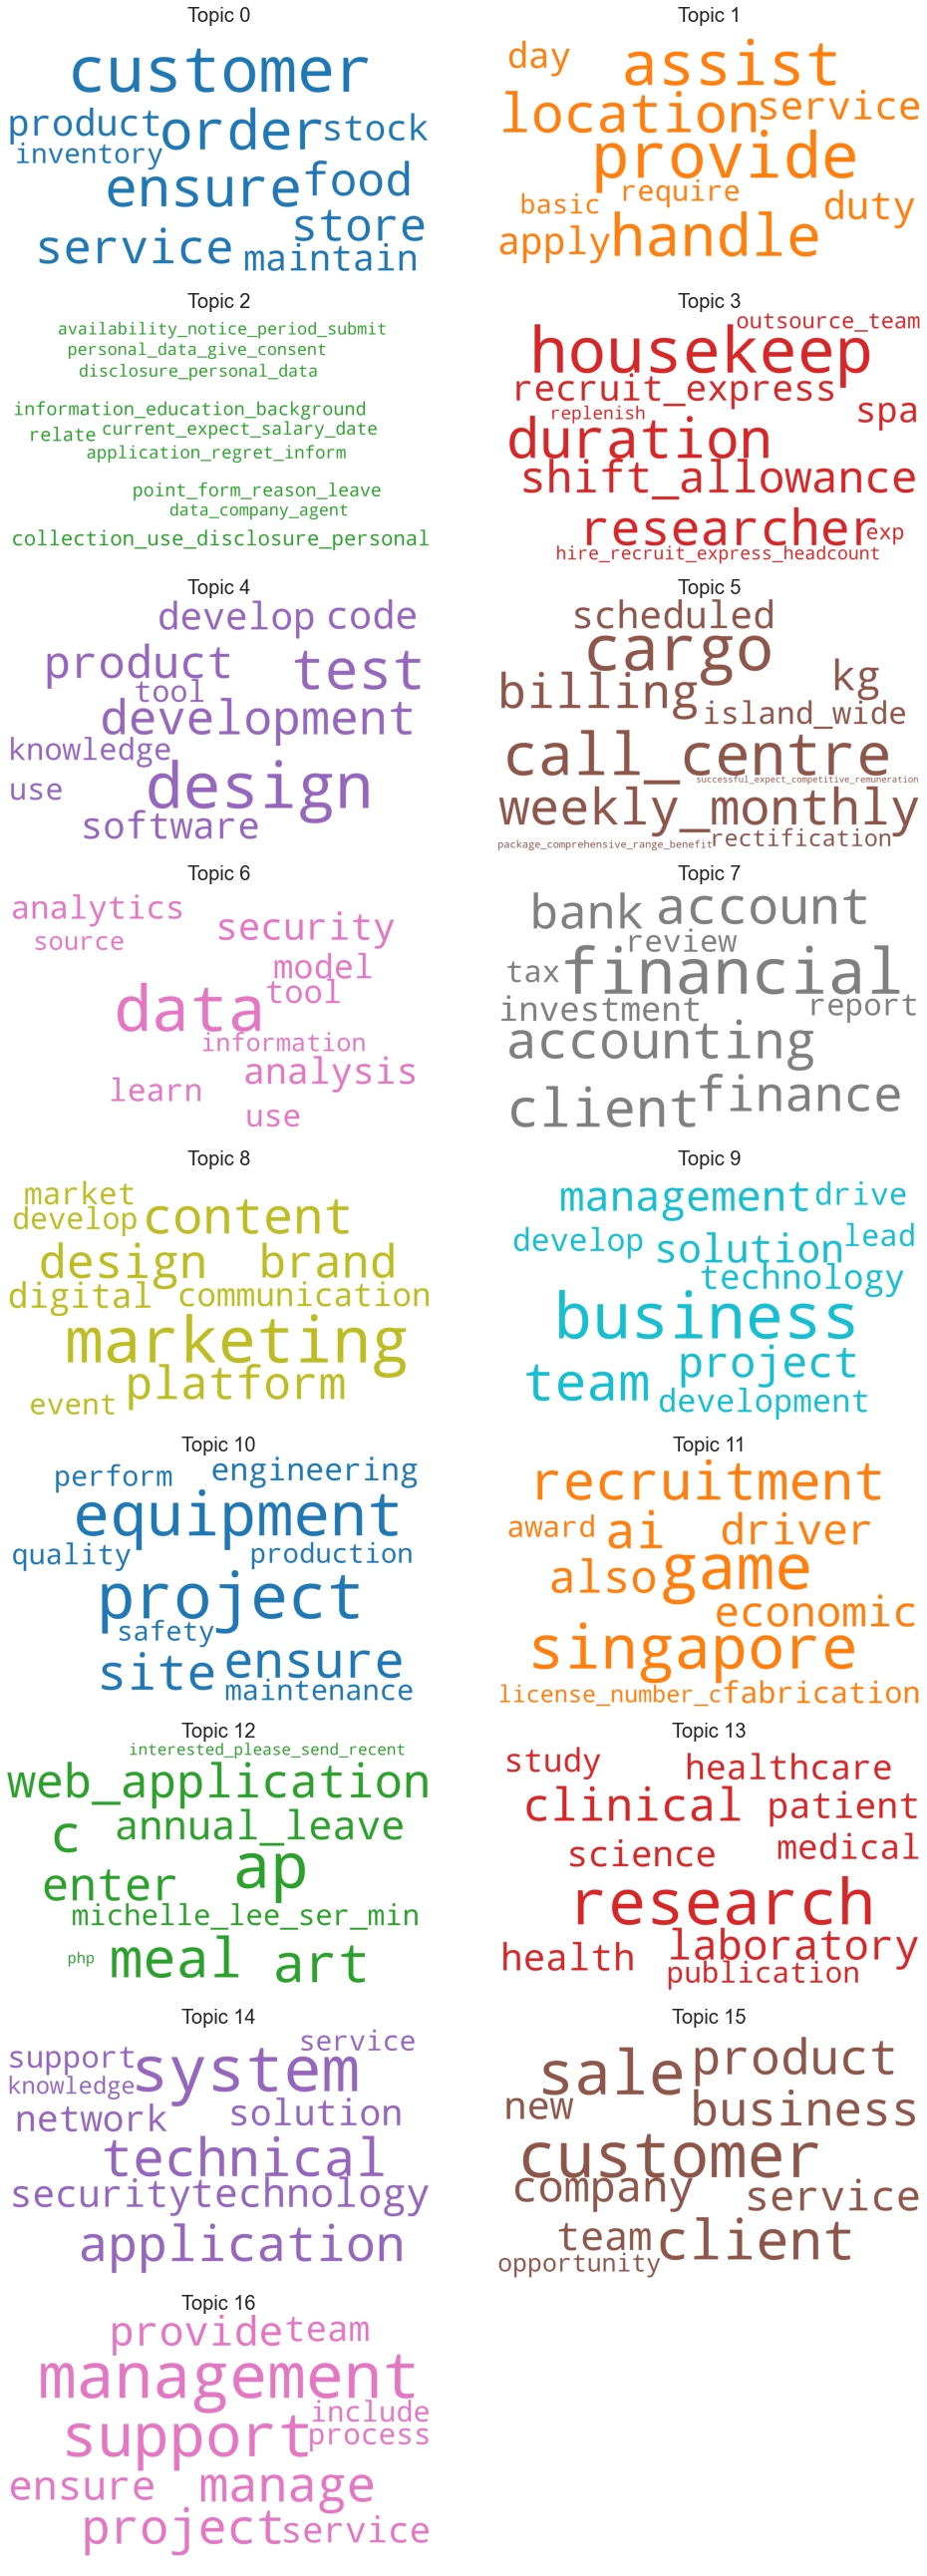

In [31]:
plot_wordcloud(lda_model_17)

Some topics are not too coherent/make much sense. 

For example:
- Topic 2: common phrases in JD (not too much use)
- Topic 3: categorize researcher with replenish, recruit_express, spa
- Topic 11: categorize recruitment, game, award, economic, AI, fabrication into the same topic

I will try the LDA Mallet model, which can perform better than the base LDA model in most situations.

## LDA Mallet Model

In [32]:
# define function to compute the coherence score of the LDA mallet model across a range of topic numbers
# plot the coherence score against the number of topics
# this function will be used to determine optimal number topics for LDA model
def compute_coherence_values_lda_mallet(processed_texts, id2word, corpus, limit, start=3, step=1):

    coherence_values = []
    model_list = []
    topic_range = range(start, limit, step)

    for num_topics in topic_range:

        lda_model = gensim.models.wrappers.LdaMallet(mallet_path,
                                                     corpus=corpus,
                                                     id2word=id2word,
                                                     num_topics=num_topics,
                                                     iterations=100,
                                                     random_seed=11)

        model_list.append(lda_model)

        coherencemodel = CoherenceModel(model=lda_model,
                                        texts=processed_texts,
                                        dictionary=id2word,
                                        coherence='c_v')

        coherence_values.append(coherencemodel.get_coherence())

    plt.plot(topic_range, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.show()

    return model_list, coherence_values

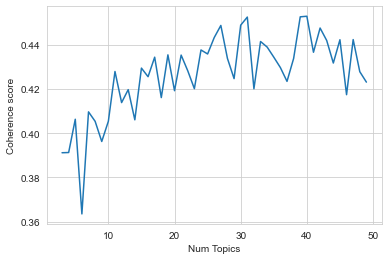

In [148]:
_, coherence_values = compute_coherence_values_lda_mallet(processed_texts=n_gram_texts,
                                                          id2word=id2word,
                                                          corpus=corpus,
                                                          start=3,
                                                          limit=50,
                                                          step=1)

In [151]:
counter = 3

for value in coherence_values:
    print(counter, round(value,4))
    counter += 1

3 0.3912
4 0.3913
5 0.4063
6 0.3635
7 0.4097
8 0.4054
9 0.3963
10 0.4054
11 0.4279
12 0.4139
13 0.4197
14 0.4061
15 0.4295
16 0.4256
17 0.4344
18 0.4161
19 0.4354
20 0.4192
21 0.4353
22 0.4282
23 0.4201
24 0.4377
25 0.4358
26 0.4433
27 0.4487
28 0.4338
29 0.4247
30 0.4489
31 0.4525
32 0.4201
33 0.4415
34 0.439
35 0.4344
36 0.4297
37 0.4234
38 0.4338
39 0.4526
40 0.4529
41 0.4366
42 0.4476
43 0.4419
44 0.4317
45 0.4423
46 0.4174
47 0.4423
48 0.4278
49 0.4231


In [33]:
lda_mallet_31 = gensim.models.wrappers.LdaMallet(mallet_path,
                                                 corpus=corpus,
                                                 id2word=id2word,
                                                 num_topics=31,
                                                 iterations=100,
                                                 random_seed=11)

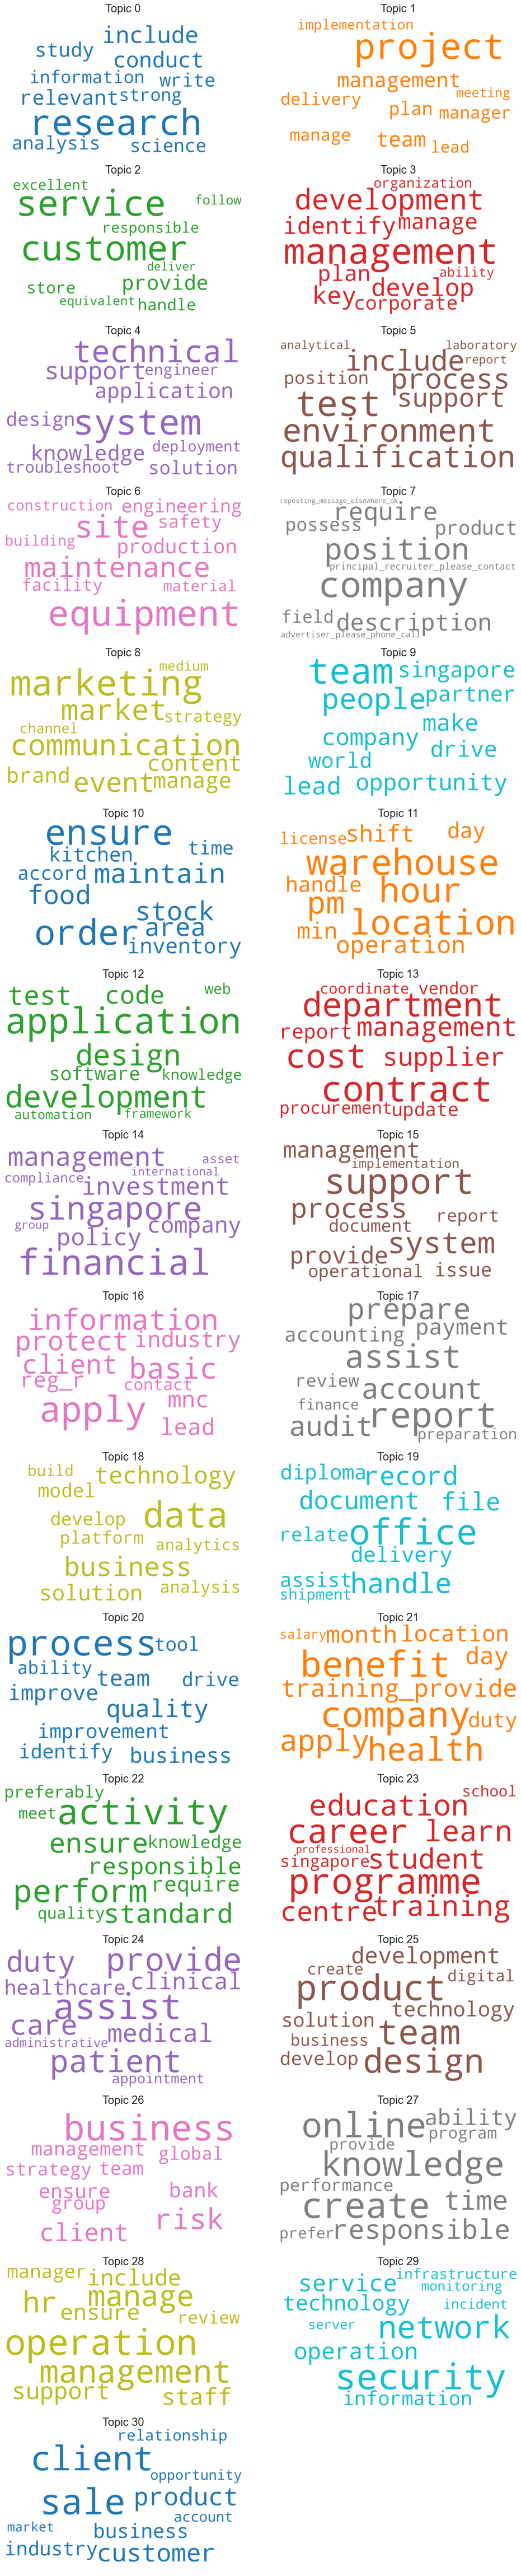

In [34]:
plot_wordcloud(lda_mallet_31)

The LDA model's topics seem much more coherent.

There are still a few topics that are less relevant (i.e. Topic 21) but the topics generated seems to have the same overarching "theme".

For example:
- Topic 0: focus on research
- Topic 1: focus on project management

In [35]:
all_doc_probabilities_tuple = lda_mallet_31[corpus]

all_doc_probabilities_dict = [{index: probability for index, probability in doc_probabilities_tuple} for doc_probabilities_tuple in all_doc_probabilities_tuple]

df_jd_topics = pd.DataFrame(all_doc_probabilities_dict)

df_jd_topics.head()

0         1         2         3         4         5         6   \
0  0.033127  0.025271  0.052207  0.027515  0.018537  0.023026  0.028638   
1  0.014942  0.018414  0.053136  0.027442  0.011470  0.010775  0.021192   
2  0.026126  0.019433  0.038174  0.019433  0.034158  0.028803  0.023449   
3  0.027428  0.047933  0.027428  0.028382  0.063670  0.016460  0.017890   
4  0.023687  0.022721  0.022721  0.019822  0.113542  0.020789  0.046875   

         7         8         9   ...        21        22        23        24  \
0  0.026393  0.037616  0.018537  ...  0.016292  0.019659  0.030882  0.016292   
1  0.038553  0.012164  0.010775  ...  0.010775  0.103136  0.012164  0.106608   
2  0.026126  0.019433  0.020771  ...  0.064948  0.159995  0.023449  0.027465   
3  0.008830  0.008353  0.030289  ...  0.006922  0.038396  0.029335  0.009307   
4  0.087455  0.024653  0.014991  ...  0.033349  0.021755  0.014991  0.022721   

         25        26        27        28        29        30  
0  0.033127  0.045473  0.019659  0.020781  0.028638  0.216067  
1  0.010081  0.019803  0.023970  0.060081  0.022581  0.011470  
2  0.022110  0.023449  0.030142  0.020771  0.019433  0.023449  
3  0.052702  0.082745  0.010260  0.019798  0.178596  0.012645  
4  0.017890  0.016924  0.037214  0.014991  0.015958  0.026586  

[5 rows x 31 columns]

In [36]:
df_jd_topics.columns = ['jd_topic_' + str(col) for col in df_jd_topics.columns]
df_jd_topics.head()

jd_topic_0  jd_topic_1  jd_topic_2  jd_topic_3  jd_topic_4  jd_topic_5  \
0    0.033127    0.025271    0.052207    0.027515    0.018537    0.023026   
1    0.014942    0.018414    0.053136    0.027442    0.011470    0.010775   
2    0.026126    0.019433    0.038174    0.019433    0.034158    0.028803   
3    0.027428    0.047933    0.027428    0.028382    0.063670    0.016460   
4    0.023687    0.022721    0.022721    0.019822    0.113542    0.020789   

   jd_topic_6  jd_topic_7  jd_topic_8  jd_topic_9  ...  jd_topic_21  \
0    0.028638    0.026393    0.037616    0.018537  ...     0.016292   
1    0.021192    0.038553    0.012164    0.010775  ...     0.010775   
2    0.023449    0.026126    0.019433    0.020771  ...     0.064948   
3    0.017890    0.008830    0.008353    0.030289  ...     0.006922   
4    0.046875    0.087455    0.024653    0.014991  ...     0.033349   

   jd_topic_22  jd_topic_23  jd_topic_24  jd_topic_25  jd_topic_26  \
0     0.019659     0.030882     0.016292     0.033127     0.045473   
1     0.103136     0.012164     0.106608     0.010081     0.019803   
2     0.159995     0.023449     0.027465     0.022110     0.023449   
3     0.038396     0.029335     0.009307     0.052702     0.082745   
4     0.021755     0.014991     0.022721     0.017890     0.016924   

   jd_topic_27  jd_topic_28  jd_topic_29  jd_topic_30  
0     0.019659     0.020781     0.028638     0.216067  
1     0.023970     0.060081     0.022581     0.011470  
2     0.030142     0.020771     0.019433     0.023449  
3     0.010260     0.019798     0.178596     0.012645  
4     0.037214     0.014991     0.015958     0.026586  

[5 rows x 31 columns]

In [37]:
df = pd.concat([df, df_jd_topics], axis = 1)
df.head()

job_id  \
0  dc4c44bf442f4baa57f22233fee9195b75d62baa3b0265...   
1  39fc119781f2337a52de7300f21b76cda9b2c0202bfec9...   
2  2bdd91d7794575aaefee738ef6c831f7129fe6172f713c...   
3  0c170932727e0246f27feb1a5641d0e26f44d26d431be6...   
4  458658ef725f6384d4c056f6a8b01747331ba7c3c5c2e5...   

                                           job_title  \
0          BUSINESS DEVELOPMENT (FREIGHT FORWARDING)   
1                                       Secretary/PA   
2  Temporary 3-6months Admin Assistant (Office ho...   
3                                 Program Management   
4  Automotive Software Engineers (C Programming /...   

                                     job_description date_posted  \
0  - Roles &amp; Responsibilities : Job Role Desc...  2020-11-27   
1  - Roles &amp; Responsibilities : Job Scope:<br...  2020-11-26   
2  Monday to Friday Office hoursLocation : Buona ...  2020-11-14   
3  - Roles &amp; Responsibilities : Key Responsib...  2020-11-09   
4  &bull; MNC&bull; $3500 - $6000 Basic + AWS + V...  2020-11-15   

                               company_name  \
0             CALL LADE ENTERPRISES PTE LTD   
1             TALENT TRADER GROUP PTE. LTD.   
2                              Confidential   
3  YASH TECHNOLOGIES SINGAPORE PTE. LIMITED   
4                              Confidential   

                                          jd_cleaned  jd_topic_0  jd_topic_1  \
0  role and responsibility job role description r...    0.033127    0.025271   
1  role and responsibility job scope full spectru...    0.014942    0.018414   
2  monday to friday office hour location buona vi...    0.026126    0.019433   
3  role and responsibility key responsibility be ...    0.027428    0.047933   
4  mnc basic aws variable bonus excellent welfare...    0.023687    0.022721   

   jd_topic_2  jd_topic_3  ...  jd_topic_21  jd_topic_22  jd_topic_23  \
0    0.052207    0.027515  ...     0.016292     0.019659     0.030882   
1    0.053136    0.027442  ...     0.010775     0.103136     0.012164   
2    0.038174    0.019433  ...     0.064948     0.159995     0.023449   
3    0.027428    0.028382  ...     0.006922     0.038396     0.029335   
4    0.022721    0.019822  ...     0.033349     0.021755     0.014991   

   jd_topic_24  jd_topic_25  jd_topic_26  jd_topic_27  jd_topic_28  \
0     0.016292     0.033127     0.045473     0.019659     0.020781   
1     0.106608     0.010081     0.019803     0.023970     0.060081   
2     0.027465     0.022110     0.023449     0.030142     0.020771   
3     0.009307     0.052702     0.082745     0.010260     0.019798   
4     0.022721     0.017890     0.016924     0.037214     0.014991   

   jd_topic_29  jd_topic_30  
0     0.028638     0.216067  
1     0.022581     0.011470  
2     0.019433     0.023449  
3     0.178596     0.012645  
4     0.015958     0.026586  

[5 rows x 37 columns]

## Examine at JD and the Topics Generated

In [38]:
all_doc_probabilities = [[probability for index, probability in doc_probabilities_tuple] for doc_probabilities_tuple in all_doc_probabilities_tuple]

topics = dict(lda_mallet_31.show_topics(num_topics=0, formatted=False))

In [39]:
def check_jd_topics(index):
    
    meaningful_topics = [all_doc_probabilities[index].index(probability) for probability in all_doc_probabilities[index] if probability > 0.1]

    print(df['jd_cleaned'][index], '\n')

    for i in meaningful_topics:
        print(i, topics[i], '\n')

In [40]:
check_jd_topics(0)

role and responsibility job role description responsible for business development for freight forward identify potential client in the target market and complete appropriate research on the prospective client s business and equipment need develop intervention strategy to mitigate gap in delivery of logistics service develop relationship with potential customer and meet sale target negotiate contract term with client actively seek out new sale opportunity through cold call networking and social medium requirement proven work experience a a business development sale executive or a relevant role experience in customer support be a plus proficiency in ms office market knowledge 

30 [('sale', 0.0987366218717309), ('client', 0.08972398809044822), ('customer', 0.04152249134948097), ('product', 0.04112014162710228), ('business', 0.025026152731954614), ('industry', 0.023899573509294277), ('relationship', 0.021083125452643438), ('account', 0.01770338778466243), ('opportunity', 0.017140098173332

In [41]:
check_jd_topics(518)

responsibility oversee and coordinate the activity of the asoc personnel support the monitoring and incident response collaborate with client to ensure that effective monitoring be implement for all environment ensure that process and procedure be follow lead the execution of response procedure to confirm track and resolve cyber security incident advise client on initial incident activity and subsequent incident activity ensure that client senior management be inform of key situation that require escalation provide weekly and monthly update requirement at least five year of experience work in a security operation center of similar size with the portfolio a a security operation center manager relevant training on the propose product and have obtain professional certification such a giac continuous monitoring certification gmon giac information assurance certify intrusion analyst gcia giac information assurance certify incident handler gcih or certify information system security professi

In [42]:
check_jd_topics(1005)

role and responsibility job description welcome and greet guest recommend and upsell meal item and advise guest on any ongoing promotion take of order serve of food and beverage to the guest answer question about our food beverage and other restaurant function and service crosscheck and ensure accuracy of food order enter order in the po system deliver food and beverage from kitchen and bar to guest in a timely matter attend and prompt response to customer s need ensure smooth operation to achieve good customer din experience maintain cleanliness and housekeeping of work area prepare table for meal any other task a assign by the manager requirement minimum secondary qualification equivalent or high good in communication and interpersonal skill candidate without work experience but have a passion for service be welcome to apply pleasant and outgo personality service orient and excellent service attitude able to maintain calmness and steady during peak timing work with passion zest energ

Looking at some random job descriptions (JDs), the topics with higher probabilities are aligned with the meaning of the JDs. However, some of the JDs have more than 1 meaningful topic. So instead of using the topics generated as labels, I will explore using them as features.

# Job Title

## Data Cleaning

In [43]:
for job in df['job_title'][:10]:
    print(job)
    print()

BUSINESS DEVELOPMENT (FREIGHT FORWARDING)

Secretary/PA

Temporary 3-6months Admin Assistant (Office hours) - JOBSTUDIO PTE LTD

Program Management

Automotive Software Engineers (C Programming / SECS / GEM / Vision System) - Ideals Recruitment Pte Ltd

Managing Consultant

Lab Technician - $1700 #ERH

Senior Software Engineer

QA / QC MANAGER (Construction) (Dredging) (2 years contract) - RS Recruitment Agency LLP

Executive/Senior Executive, Graduate Studies (School of Computing)



In [44]:
df['job_title_cleaned'] = df['job_title'].map(lambda x: clean_text(x))

In [45]:
for text in df['job_title_cleaned'][:10]:
    print(text, '\n')

business development freight forwarding  

secretary pa 

temporary months admin assistant office hours jobstudio pte ltd 

program management 

automotive software engineers c programming secs gem vision system ideals recruitment pte ltd 

managing consultant 

lab technician erh 

senior software engineer 

qa qc manager construction dredging years contract rs recruitment agency llp 

executive senior executive graduate studies school of computing  



In [46]:
for index in sample(range(len(df['job_title_cleaned'])), 10):
    print(index)
    print(df['job_title_cleaned'][index], '\n')

1518
r d chemist up to k tuas oil gas water treatment ideals recruitment pte ltd 

2199
department manager don don donki 

2048
beauty consultant 

2514
telemarketer 

1789
roboticist 

1321
digitalization ecommerce manager european mnc b c luxury goods k  

2267
system analyst medical it up to k sdlc achieve career consultant pte ltd 

2981
junior software developer kelly services s pte ltd 

802
paralegal legal executive  

49
mobile crane operator construction a main con hs mci career services pte ltd 



Some Keywords:
- Contract Jobs: contract, temporary, temp, months, mths
- Traineeships: traineeships, trainee, intern,
- SG United Roles: sg united, sg unitedjobs

These are attributed of the jobs that can be extracted.

Words to remove: pte, ltd, private, limited, singapore

In [47]:
def identify_job_type(job_title, words):
    for word in words:
        if word in job_title:
            return 1

    return 0

def identify_job_type_pair(job_title, word_pairs):
    for word_pair in word_pairs:
        if word_pair[0] in job_title and word_pair[1] in job_title:
            return 1

    return 0

In [48]:
df['is_contract'] = df['job_title_cleaned'].map(lambda x: 
                                                identify_job_type(x, ['contract', 'temporary', 'temp', 'months', 'mths']))

df['is_traineeship'] = df['job_title_cleaned'].map(lambda x: 
                                                identify_job_type(x, ['traineeship', 'traineeships', 'trainee', 'trainees']))

df['is_internship'] = df['job_title_cleaned'].map(lambda x: 
                                                identify_job_type(x, ['intern', 'internship']))

df['is_sg_united'] = df['job_title_cleaned'].map(lambda x: 
                                                 identify_job_type_pair(x, [('sg', 'united'), ('sg', 'unitedjobs')]))

In [49]:
df.columns

Index(['job_id', 'job_title', 'job_description', 'date_posted', 'company_name',
       'jd_cleaned', 'jd_topic_0', 'jd_topic_1', 'jd_topic_2', 'jd_topic_3',
       'jd_topic_4', 'jd_topic_5', 'jd_topic_6', 'jd_topic_7', 'jd_topic_8',
       'jd_topic_9', 'jd_topic_10', 'jd_topic_11', 'jd_topic_12',
       'jd_topic_13', 'jd_topic_14', 'jd_topic_15', 'jd_topic_16',
       'jd_topic_17', 'jd_topic_18', 'jd_topic_19', 'jd_topic_20',
       'jd_topic_21', 'jd_topic_22', 'jd_topic_23', 'jd_topic_24',
       'jd_topic_25', 'jd_topic_26', 'jd_topic_27', 'jd_topic_28',
       'jd_topic_29', 'jd_topic_30', 'job_title_cleaned', 'is_contract',
       'is_traineeship', 'is_internship', 'is_sg_united'],
      dtype='object')

In [50]:
df[['is_contract', 'is_traineeship', 'is_internship','is_sg_united']].sum()

is_contract       290
is_traineeship    112
is_internship      63
is_sg_united      176
dtype: int64

In [51]:
df[(df['is_traineeship'] == 1) & (df['is_sg_united'] == 1)][['job_title_cleaned', 'is_traineeship', 'is_sg_united']]

job_title_cleaned  is_traineeship  \
99     br computer system validation cum business an...               1   
140   accounts executive accounts payable sg united ...               1   
166   sg united traineeship program technician ie pl...               1   
221                 data engineer sg united traineeship               1   
248   graphics designer sg united traineeship wizlea...               1   
...                                                 ...             ...   
2828    legal compliance trainee sg united traineeships               1   
2867  sg united traineeship program technician ssd a...               1   
2884                    engineer sg united traineeships               1   
2984  customer service executive sg united traineeships               1   
2994   software engineer backend sg united traineeships               1   

      is_sg_united  
99               1  
140              1  
166              1  
221              1  
248              1  
...            ...  
2828             1  
2867             1  
2884             1  
2984             1  
2994             1  

[91 rows x 3 columns]

For SG United column, I am intending it to be SG United jobs, not SG United traineeships, as most traineeships should be from SG United. 

Hence, if a job is a traineeship, it should not be a SG United job.

In [52]:
def check_traineeship(row):
    if row.is_sg_united == 1 & row.is_traineeship == 1:
        return 0
    else:
        return row.is_sg_united
    
df['is_sg_united'] = df.apply(lambda x: check_traineeship(x), axis = 1)

df[['is_contract', 'is_traineeship', 'is_internship','is_sg_united']].sum()

is_contract       290
is_traineeship    112
is_internship      63
is_sg_united       85
dtype: int64

In [53]:
def remove_words(sentence, words_to_remove):
    
    words = nltk.word_tokenize(sentence)
    
    words_left = [word for word in words if word not in words_to_remove]
    
    return ' '.join(words_left)

words_to_remove = ['contract', 'temporary', 'temp', 'months', 'mths', 'traineeship', 'traineeships', 'trainee', 'trainees', 'intern', 'sg', 'united', 'unitedjobs', 'pte', 'ltd', 'private', 'limited', 'singapore']

df['job_title_cleaned'] = df['job_title_cleaned'].map(lambda x: remove_words(x, words_to_remove))

In [54]:
df[['job_title_cleaned', 'is_contract', 'is_traineeship', 'is_internship','is_sg_united']].head(10)

job_title_cleaned  is_contract  \
0            business development freight forwarding            0   
1                                       secretary pa            0   
2             admin assistant office hours jobstudio            1   
3                                 program management            0   
4  automotive software engineers c programming se...            0   
5                                managing consultant            0   
6                                 lab technician erh            0   
7                           senior software engineer            0   
8  qa qc manager construction dredging years rs r...            1   
9  executive senior executive graduate studies sc...            0   

   is_traineeship  is_internship  is_sg_united  
0               0              0             0  
1               0              0             0  
2               0              0             0  
3               0              0             0  
4               0              0             0  
5               0              0             0  
6               0              0             0  
7               0              0             0  
8               0              0             0  
9               0              0             0

## EDA

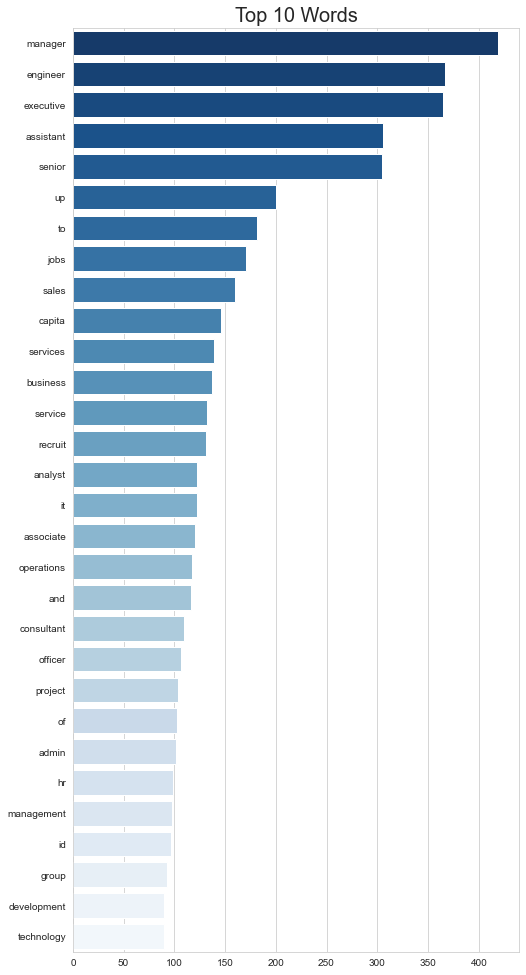

In [55]:
plot_top_n_kgram_words(df['job_title_cleaned'], 30, 1, stopwords = None, title = 'Top 10 Words')

Words to remove: up, to, job, capita, it, and, of, hr, id

In [56]:
words_to_remove = ['up', 'to', 'job', 'jobs', 'capita', 'it', 'and', 'of', 'hr', 'id']

df['job_title_cleaned'] = df['job_title_cleaned'].map(lambda x: remove_words(x, words_to_remove))

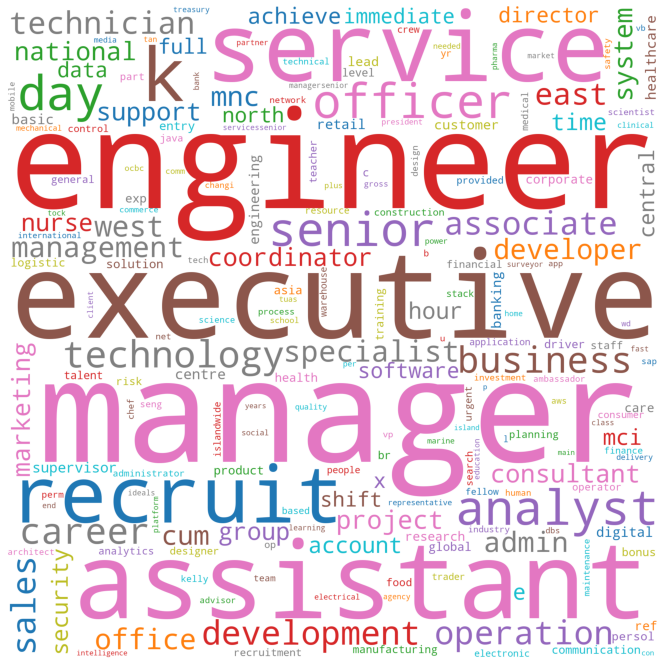

In [57]:
wordcloud = WordCloud(width=2000, 
                      height=2000,
                      background_color='white',
                      colormap = 'tab10',
                      random_state=11, 
                      collocations=False, 
                      stopwords=stop_words).generate(df['job_title_cleaned'].str.cat())

plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

There are a number of words that does not contribute to the job's meaning (i.e. north, east, west, islandwide, year, month, etc). I will remove these words.

Some clear job roles can be seen from the wordcloud: engineer, manager, analyst, developer, technician, security, intelligence, nurse, chef, architect, designer, teacher

In [58]:
words_to_remove = ['east', 'k', 'islandwide', 'based', 'kelly', 'north', 'year', 'urgent', 'west', 'south', 'time', 'marina', 'day', 'yr', 'seng', 'sgup', 'tan', 'tuas', 'vb', 'e', 'x', 'l', 'tock', 'br', 'per', 'u', 'b', 'work', 'immediate', 'perm']

df['job_title_cleaned'] = df['job_title_cleaned'].map(lambda x: remove_words(x, words_to_remove))

In [59]:
for index in sample(range(len(df['job_title_cleaned'])), 5):
    print(index)
    print()
    print(df['job_title'][index], '\n', df['job_title_cleaned'][index], '\n')

785

Cashiers / Retail Assistant ( Major Supermarkets / Islandwide! ) - RecruitFirst Pte. Ltd 
 cashiers retail assistant major supermarkets recruit first 

765

Senior Recruitment Consultant 
 senior recruitment consultant 

1799

Clinician 
 clinician 

2929

OPERATIONS TECHNICIAN (OIL & GAS) - Petracarbon 
 operations technician oil gas petracarbon 

1837

Literature Tuition – Professional Tutors (2 to Over 30 Years Tut 
 literature tuition professional tutors over years tut 



## LDA Mallet Model

In [60]:
# define function to tokenize, create bigrams and trigrams
def create_ngrams_no_stopwords(corpus):
    
    texts = [nltk.word_tokenize(sentence) for sentence in corpus]
    
    # build the bigram and trigram models by automatically detecting common phrases / multiword expressions
    # min_count ignores all words and bigrams with total count less than the number
    # threshold affects the number of phrases that will be created (higher threshold = fewer phrases)
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=20)
    trigram = gensim.models.Phrases(bigram[texts], threshold=20)

    # a phrases object is for learning bigrams (and multiword expressions), not for processing
    # for processing, need to use a phraser object
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
 
    # combines bi-gram phrases
    texts_w_bigrams = [bigram_mod[sentence] for sentence in texts]
    
    # combines tri-gram phrases
    texts_w_trigrams = [trigram_mod[bigram_mod[sentence]] for sentence in texts_w_bigrams]
    
    return texts_w_trigrams

In [61]:
title_n_gram_texts = create_ngrams_no_stopwords(df['job_title_cleaned'])

In [62]:
# create a new dictionary of interger numbers and unique words in the entire dataset
id2word = corpora.Dictionary(title_n_gram_texts)

# create the term document frequency corpus
corpus = [id2word.doc2bow(text) for text in title_n_gram_texts]

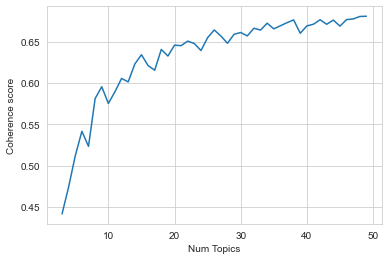

In [128]:
_, coherence_values = compute_coherence_values_lda_mallet(processed_texts=title_n_gram_texts,
                                                          id2word=id2word,
                                                          corpus=corpus,
                                                          start=3,
                                                          limit=50,
                                                          step=1)

In [129]:
counter = 3

for value in coherence_values:
    print(counter, round(value,4))
    counter += 1

3 0.4416
4 0.4744
5 0.512
6 0.5416
7 0.5234
8 0.5813
9 0.5956
10 0.5753
11 0.5896
12 0.6056
13 0.6014
14 0.6231
15 0.6343
16 0.6213
17 0.6156
18 0.6407
19 0.6328
20 0.6459
21 0.6454
22 0.6508
23 0.6478
24 0.6394
25 0.655
26 0.6643
27 0.6571
28 0.6482
29 0.6591
30 0.6613
31 0.6572
32 0.6664
33 0.6642
34 0.6726
35 0.6657
36 0.6694
37 0.6731
38 0.6765
39 0.6604
40 0.6692
41 0.6713
42 0.6767
43 0.6712
44 0.6763
45 0.669
46 0.6769
47 0.6776
48 0.6807
49 0.681


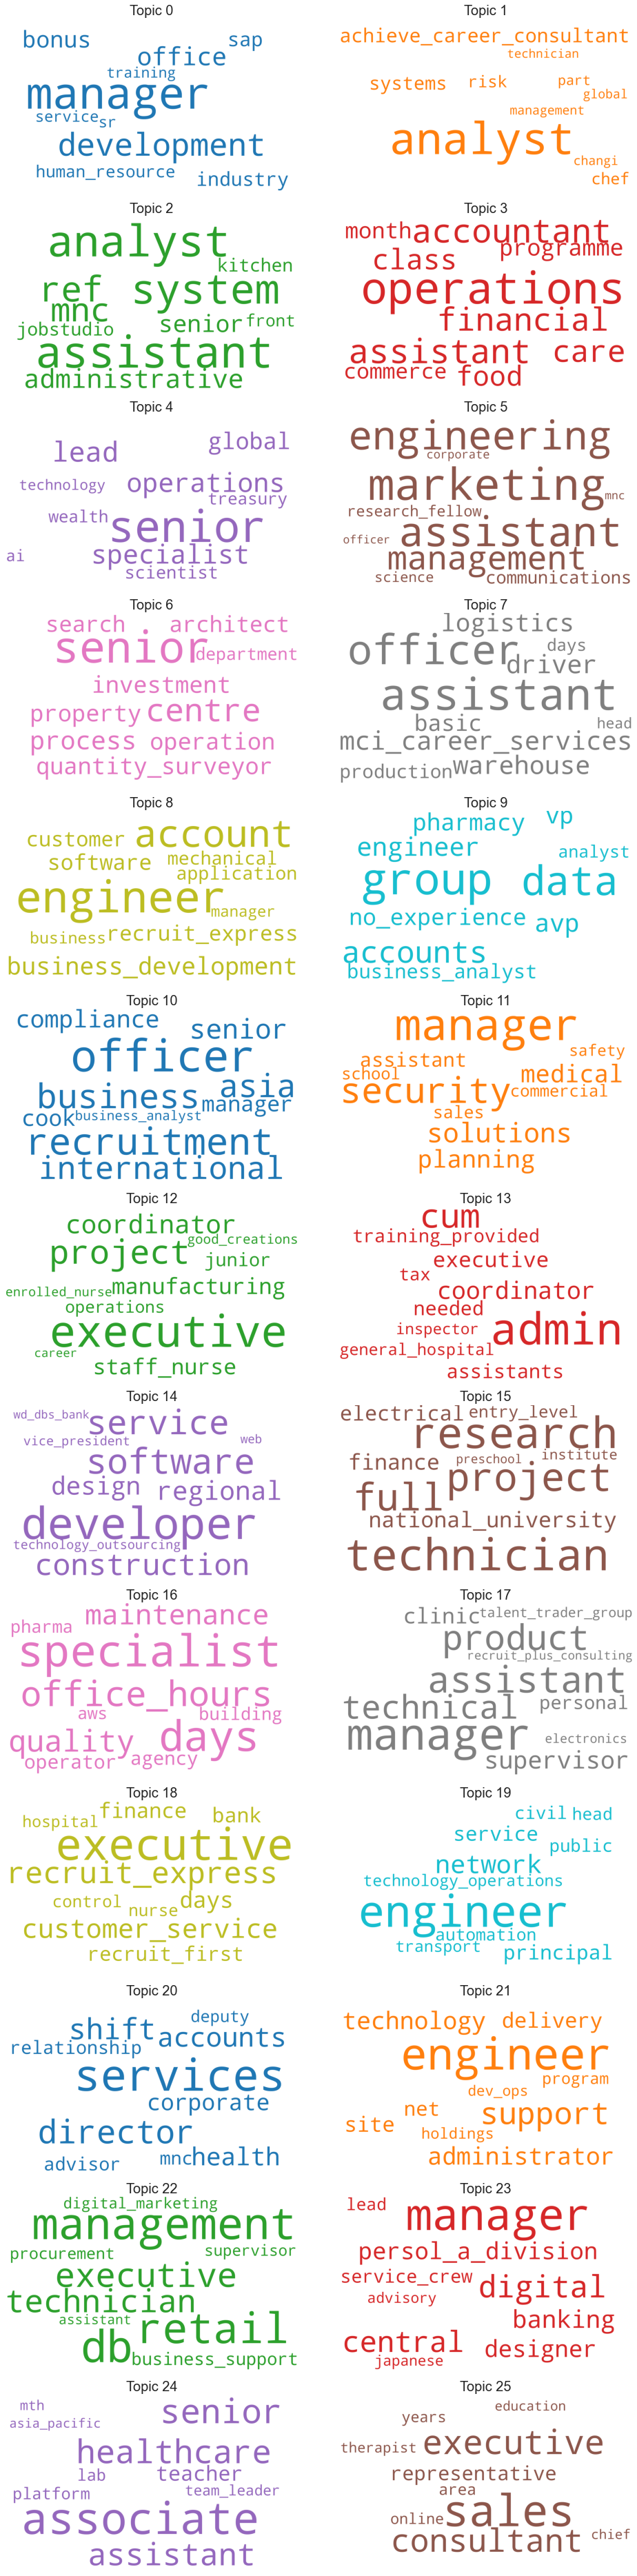

In [63]:
lda_mallet_title = gensim.models.wrappers.LdaMallet(mallet_path,
                                                    corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=26,
                                                    iterations=100,
                                                    random_seed=11)

plot_wordcloud(lda_mallet_title)

The LDA model ended up grouping different roles that are not too similar together.

For example:
- Topic 2 contains "kitchen", "analyst", "studio"
- Topic 3 contains "operations", "accountant", "financial" and "food"

Hence, the topics obtained are not too meaningful. I will manually create a few features based on strong words that have association towards specific jobs/roles as seen on the wordcloud.

## Creating Common Job Features

In [64]:
common_job_title_roles = ['engineer', 'technician', 'developer', 'manager', 'analyst', 'security', 'intelligence', 'nurse', 'chef', 'architect', 'designer', 'teacher']

for role in common_job_title_roles:
    role_name = 'job_role_' + role
    df[role_name] = df['job_title_cleaned'].map(lambda x:
                                                identify_job_type(x, [role]))
    
df.columns

Index(['job_id', 'job_title', 'job_description', 'date_posted', 'company_name',
       'jd_cleaned', 'jd_topic_0', 'jd_topic_1', 'jd_topic_2', 'jd_topic_3',
       'jd_topic_4', 'jd_topic_5', 'jd_topic_6', 'jd_topic_7', 'jd_topic_8',
       'jd_topic_9', 'jd_topic_10', 'jd_topic_11', 'jd_topic_12',
       'jd_topic_13', 'jd_topic_14', 'jd_topic_15', 'jd_topic_16',
       'jd_topic_17', 'jd_topic_18', 'jd_topic_19', 'jd_topic_20',
       'jd_topic_21', 'jd_topic_22', 'jd_topic_23', 'jd_topic_24',
       'jd_topic_25', 'jd_topic_26', 'jd_topic_27', 'jd_topic_28',
       'jd_topic_29', 'jd_topic_30', 'job_title_cleaned', 'is_contract',
       'is_traineeship', 'is_internship', 'is_sg_united', 'job_role_engineer',
       'job_role_technician', 'job_role_developer', 'job_role_manager',
       'job_role_analyst', 'job_role_security', 'job_role_intelligence',
       'job_role_nurse', 'job_role_chef', 'job_role_architect',
       'job_role_designer', 'job_role_teacher'],
      dtype='object')

In [65]:
df[['job_role_engineer', 'job_role_technician',
    'job_role_developer', 'job_role_manager', 'job_role_analyst',
    'job_role_security', 'job_role_intelligence', 'job_role_nurse',
    'job_role_chef', 'job_role_architect', 'job_role_designer',
    'job_role_teacher']].sum()

job_role_engineer        404
job_role_technician       90
job_role_developer        88
job_role_manager         381
job_role_analyst         121
job_role_security         54
job_role_intelligence     10
job_role_nurse            42
job_role_chef             40
job_role_architect        27
job_role_designer         30
job_role_teacher          28
dtype: int64

# Company Name

## Data Cleaning

In [66]:
for jd in df['company_name'][:5]:
    print(jd)
    print()

CALL LADE ENTERPRISES PTE LTD

TALENT TRADER GROUP PTE. LTD.

Confidential

YASH TECHNOLOGIES SINGAPORE PTE. LIMITED

Confidential



In [67]:
df['company_name_cleaned'] = df['company_name'].map(lambda x: clean_text(x))

for text in df['company_name_cleaned'][:5]:
    print(text, '\n')

call lade enterprises pte ltd 

talent trader group pte ltd  

confidential 

yash technologies singapore pte limited 

confidential 



In [68]:
for index in sample(range(len(texts)), 5):
    print(index)
    print(df['company_name_cleaned'][index], '\n')

922
confidential 

326
recruitflash pte ltd  

2200
confidential 

2967
recruit express 

2530
titansoft pte ltd  



In [69]:
df['company_name_cleaned'].nunique()

894

## EDA

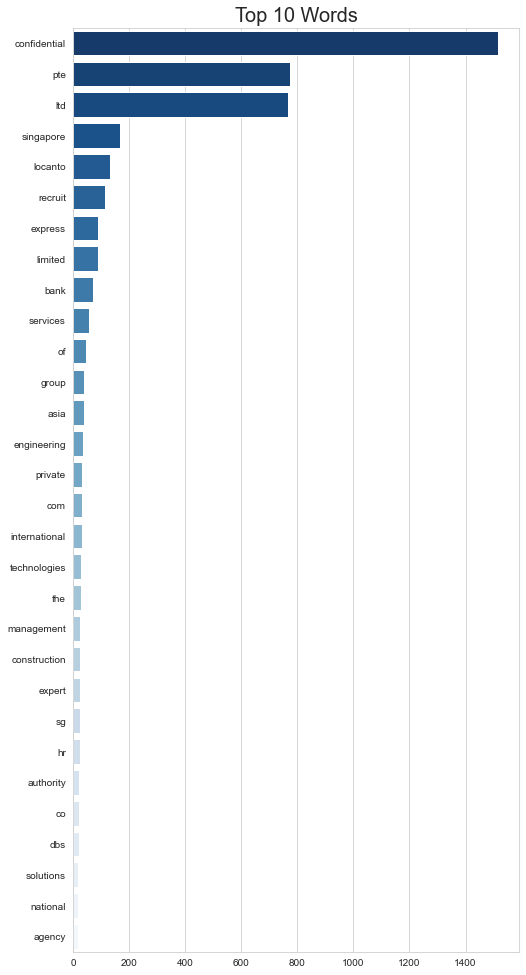

In [70]:
plot_top_n_kgram_words(df['company_name_cleaned'], 30, 1, stopwords = None, title = 'Top 10 Words')

There does not seem to be much information that I can extract from the company names. To clean the names further, I will likely have to look through the names which has about 900 entries. I will leave that for now to try to create a model that can classify the job type.

# Clustering Model
I have created a number of new features (topics from job description and type of job roles) that are essentially "attributes" of the job posted. I will attempt to create a clustering model to learn and group similar jobs/roles automatically based on these features.

In [71]:
X = df[['jd_topic_0', 'jd_topic_1', 'jd_topic_2', 'jd_topic_3',
        'jd_topic_4', 'jd_topic_5', 'jd_topic_6', 'jd_topic_7', 'jd_topic_8',
        'jd_topic_9', 'jd_topic_10', 'jd_topic_11', 'jd_topic_12',
        'jd_topic_13', 'jd_topic_14', 'jd_topic_15', 'jd_topic_16',
        'jd_topic_17', 'jd_topic_18', 'jd_topic_19', 'jd_topic_20',
        'jd_topic_21', 'jd_topic_22', 'jd_topic_23', 'jd_topic_24',
        'jd_topic_25', 'jd_topic_26', 'jd_topic_27', 'jd_topic_28',
        'jd_topic_29', 'jd_topic_30', 'job_role_engineer',
        'job_role_technician', 'job_role_developer', 'job_role_manager',
        'job_role_analyst', 'job_role_security', 'job_role_intelligence',
        'job_role_nurse', 'job_role_chef', 'job_role_architect',
        'job_role_designer', 'job_role_teacher']].copy()

In [72]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   jd_topic_0             3000 non-null   float64
 1   jd_topic_1             3000 non-null   float64
 2   jd_topic_2             3000 non-null   float64
 3   jd_topic_3             3000 non-null   float64
 4   jd_topic_4             3000 non-null   float64
 5   jd_topic_5             3000 non-null   float64
 6   jd_topic_6             3000 non-null   float64
 7   jd_topic_7             3000 non-null   float64
 8   jd_topic_8             3000 non-null   float64
 9   jd_topic_9             3000 non-null   float64
 10  jd_topic_10            3000 non-null   float64
 11  jd_topic_11            3000 non-null   float64
 12  jd_topic_12            3000 non-null   float64
 13  jd_topic_13            3000 non-null   float64
 14  jd_topic_14            3000 non-null   float64
 15  jd_t

In [73]:
ss = StandardScaler()
X_ss = ss.fit_transform(X)

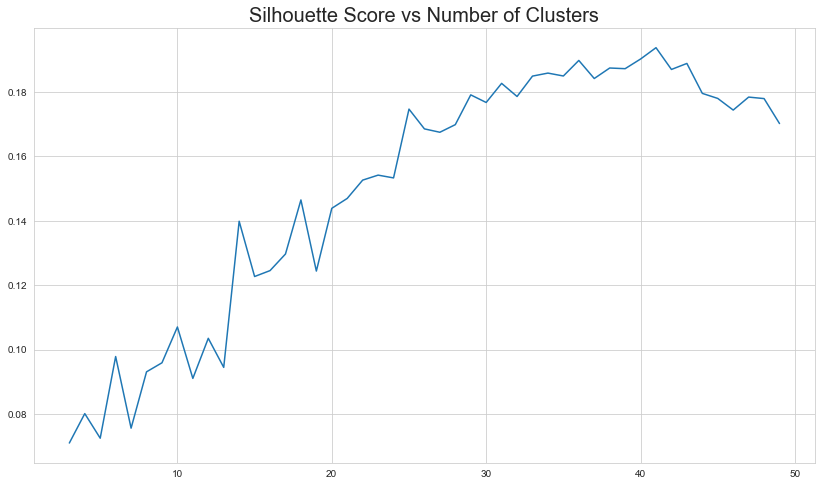

In [74]:
sil_score = []
upper_limit = 50

for n in range(3, upper_limit):
    km = KMeans(n_clusters=n, random_state=11)
    km.fit(X_ss)
    sil_score.append(silhouette_score(X_ss, km.labels_))

plt.figure(figsize = (14, 8))
plt.plot(list(range(3, upper_limit)), sil_score)
plt.title('Silhouette Score vs Number of Clusters', fontsize = 20)
plt.show()

In [75]:
for cluster in range(30, 50):
    print(f'Cluster {cluster}: {round(sil_score[cluster-3], 4)}')

Cluster 30: 0.1767
Cluster 31: 0.1827
Cluster 32: 0.1786
Cluster 33: 0.1849
Cluster 34: 0.1859
Cluster 35: 0.185
Cluster 36: 0.1898
Cluster 37: 0.1842
Cluster 38: 0.1874
Cluster 39: 0.1872
Cluster 40: 0.1902
Cluster 41: 0.1937
Cluster 42: 0.187
Cluster 43: 0.1889
Cluster 44: 0.1796
Cluster 45: 0.178
Cluster 46: 0.1744
Cluster 47: 0.1784
Cluster 48: 0.1779
Cluster 49: 0.1702


In general, this silhouette score is not too good, silhouette score range from -1 to 1. A score that is close to 0, suggests that there is not much difference between the clusters.

However, I will explore the model with 41 clusters which obtained the highest score.

In [76]:
km = KMeans(n_clusters=41, random_state=11)
km.fit(X_ss)

KMeans(n_clusters=41, random_state=11)

### Exploring the Model

In [77]:
cluster_centers = pd.DataFrame(ss.inverse_transform(km.cluster_centers_), columns = X.columns)
cluster_centers.head()

jd_topic_0  jd_topic_1  jd_topic_2  jd_topic_3  jd_topic_4  jd_topic_5  \
0    0.035187    0.022526    0.019811    0.043765    0.014009    0.023040   
1    0.021436    0.030963    0.027744    0.022245    0.116654    0.027249   
2    0.019379    0.020770    0.033910    0.034436    0.021432    0.023555   
3    0.024661    0.039217    0.027025    0.029432    0.020170    0.023304   
4    0.023773    0.026759    0.021714    0.024615    0.061018    0.029684   

   jd_topic_6  jd_topic_7  jd_topic_8  jd_topic_9  ...  job_role_developer  \
0    0.016536    0.022191    0.022462    0.040983  ...        3.469447e-18   
1    0.024786    0.022615    0.019674    0.021513  ...        0.000000e+00   
2    0.017711    0.022404    0.051478    0.193624  ...        1.369863e-02   
3    0.051224    0.030588    0.019620    0.022870  ...        3.469447e-18   
4    0.014560    0.022121    0.021052    0.026623  ...        1.000000e+00   

   job_role_manager  job_role_analyst  job_role_security  \
0      5.405405e-02     -1.387779e-17       0.000000e+00   
1      1.063830e-02      4.255319e-02       0.000000e+00   
2      2.328767e-01      0.000000e+00       3.469447e-18   
3      7.228916e-02     -6.938894e-18       0.000000e+00   
4     -2.775558e-17      2.500000e-02       0.000000e+00   

   job_role_intelligence  job_role_nurse  job_role_chef  job_role_architect  \
0           0.000000e+00    1.734723e-18   1.734723e-18       -1.734723e-18   
1           4.336809e-19    0.000000e+00   0.000000e+00        0.000000e+00   
2           0.000000e+00    1.734723e-18   3.469447e-18        0.000000e+00   
3           0.000000e+00    0.000000e+00   0.000000e+00        0.000000e+00   
4           0.000000e+00    0.000000e+00   3.469447e-18       -1.734723e-18   

   job_role_designer  job_role_teacher  
0      -1.734723e-18      0.000000e+00  
1      -1.734723e-18      3.469447e-18  
2      -3.469447e-18      1.734723e-18  
3      -3.469447e-18      1.734723e-18  
4      -1.734723e-18      0.000000e+00  

[5 rows x 43 columns]

In [78]:
cluster_centers.iloc[4].sort_values(ascending = False).head(5)

job_role_developer    1.000000
jd_topic_12           0.198414
jd_topic_25           0.067798
jd_topic_4            0.061018
jd_topic_18           0.055621
Name: 4, dtype: float64

In [79]:
# define a function to return only the topics that I am interested in
def plot_wordcloud(topics_dict, topic_index):
    
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] * 5

    cloud = WordCloud(background_color='white',
                      width=2000,
                      height=1200,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0,)

    num_topics = len(topic_index)
    num_rows = math.ceil(num_topics/2)

    fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 4), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        if i < num_topics:
            fig.add_subplot(ax)
            topic_words = dict(topics_dict[topic_index[i]])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.title('Topic ' + str(topic_index[i]), fontsize=20)
            plt.gca().axis('off')
        else:
            fig.delaxes(ax) 

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()
    
jd_topics = lda_mallet_31.show_topics(num_topics=0, formatted=False)
jd_topics = dict(jd_topics)

In [80]:
cluster_centers.iloc[15].sort_values(ascending = False).head(5)

job_role_technician    1.000000
jd_topic_6             0.123022
job_role_engineer      0.093023
jd_topic_11            0.049500
jd_topic_21            0.046819
Name: 15, dtype: float64

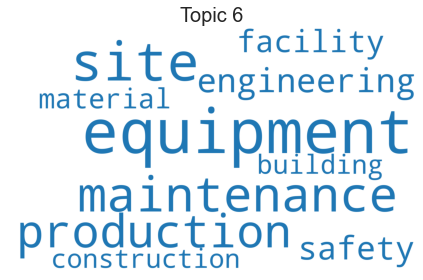

In [81]:
plot_wordcloud(jd_topics, [6])

In [82]:
cluster_centers.iloc[4].sort_values(ascending = False).head(5)

job_role_developer    1.000000
jd_topic_12           0.198414
jd_topic_25           0.067798
jd_topic_4            0.061018
jd_topic_18           0.055621
Name: 4, dtype: float64

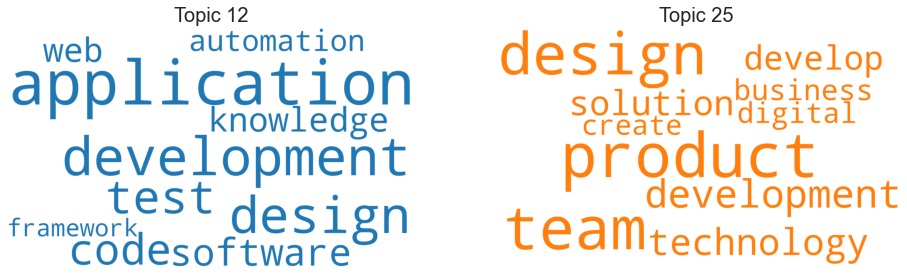

In [83]:
plot_wordcloud(jd_topics, [12, 25])

The clusters created seem coherent. The job role and the JD topics with high coefficients are aligned in direction.

For example:
- Cluster 15 is a technician role with focus on safety and maintenance of site and equipment responsibility.
- Cluster 4 is an software developer role

In [84]:
df['clustering_labels'] = km.labels_
df.head(1)

job_id  \
0  dc4c44bf442f4baa57f22233fee9195b75d62baa3b0265...   

                                   job_title  \
0  BUSINESS DEVELOPMENT (FREIGHT FORWARDING)   

                                     job_description date_posted  \
0  - Roles &amp; Responsibilities : Job Role Desc...  2020-11-27   

                    company_name  \
0  CALL LADE ENTERPRISES PTE LTD   

                                          jd_cleaned  jd_topic_0  jd_topic_1  \
0  role and responsibility job role description r...    0.033127    0.025271   

   jd_topic_2  jd_topic_3  ...  job_role_analyst  job_role_security  \
0    0.052207    0.027515  ...                 0                  0   

   job_role_intelligence  job_role_nurse  job_role_chef  job_role_architect  \
0                      0               0              0                   0   

   job_role_designer  job_role_teacher           company_name_cleaned  \
0                  0                 0  call lade enterprises pte ltd   

   clustering_labels  
0                 25  

[1 rows x 56 columns]

In [85]:
# define function to look at the jd, and the outcomes of the clustering model
def examine_clustering(index):
    print(df.iloc[index]['jd_cleaned'],'\n')
    print(cluster_centers.iloc[df.iloc[index]['clustering_labels']].sort_values(ascending = False).head(5))

In [86]:
examine_clustering(10)

role and responsibility coordination and management of all mand e work ensure all mand e work be perform on time within budget and in compliance with all necessary standard code of practice and safety regulation ensure that all mand e work will achieve the high quality level expect high conquas and quality mark responsible for the supervision and coordination of mand e work at project site understand main contract subcontract requirement prepare and submit material submission and sample submission check for discrepancy defect inconsistency in construction drawing monitor progress quality of workmanship and compliance with requirement supervise track on go site work on master program prepare mand e coordination drawing and liaise with architectural coordinator and design engineer to issue shop draw for approval prepare structural penetration shop draw for approval ass and verify mand e sub contractor claim conduct mand e co ordination meeting 

job_role_engineer    0.650000
jd_topic_6  

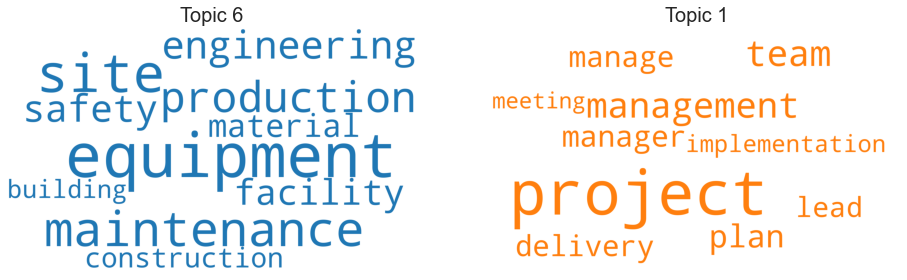

In [87]:
plot_wordcloud(jd_topics, [6, 1])

The cluster is also reasonably coherent with the job description.